<a href="https://colab.research.google.com/github/HEVNAGI/CSST106-CS4B/blob/main/4B_MAGPANTAY_MIDTERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from pathlib import Path
import random

In [5]:
labels_path = '/content/coco.names'

In [6]:
# Load labels
labels = open(labels_path).read().strip().split('\n')
print (labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2024-10-13 13:50:11--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  40.1MB/s    in 6.0s    

2024-10-13 13:50:17 (39.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-13 13:50:17--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [8]:
import tensorflow as tf
import cv2
import numpy as np

# Load YOLOv3 model
def load_yolo_model(weights_path, config_path):
    net = cv2.dnn.readNet(weights_path, config_path)
    return net

# Specify paths
weights_path = '/content/yolov3.weights'
config_path = '/content/yolov3.cfg'

# Load the model
yolo_model = load_yolo_model(weights_path, config_path)

# Print model information
print("YOLOv3 model loaded successfully!")

YOLOv3 model loaded successfully!


In [10]:
# Load YOLO network
network = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Get output layers
layers_names_all = network.getLayerNames()
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]
print(layers_names_output)
# Set parameters
probability_minimum = 0.5
threshold = 0.3

['yolo_82', 'yolo_94', 'yolo_106']


In [17]:
def yolo_detection(image_path):
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)

    # Initialize the lists to hold results
    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    # Perform Non-Maximum Suppression
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    return image, bounding_boxes, confidences, class_numbers, results if len(results) > 0 else []


In [18]:
def draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results):
    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            colour_box_current = [int(j) for j in np.random.randint(0, 255, size=3)]

            cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            text_box_current = f'{labels[int(class_numbers[i])]}: {confidences[i]:.4f}'

            cv2.putText(image, text_box_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, colour_box_current, 2)

    return image

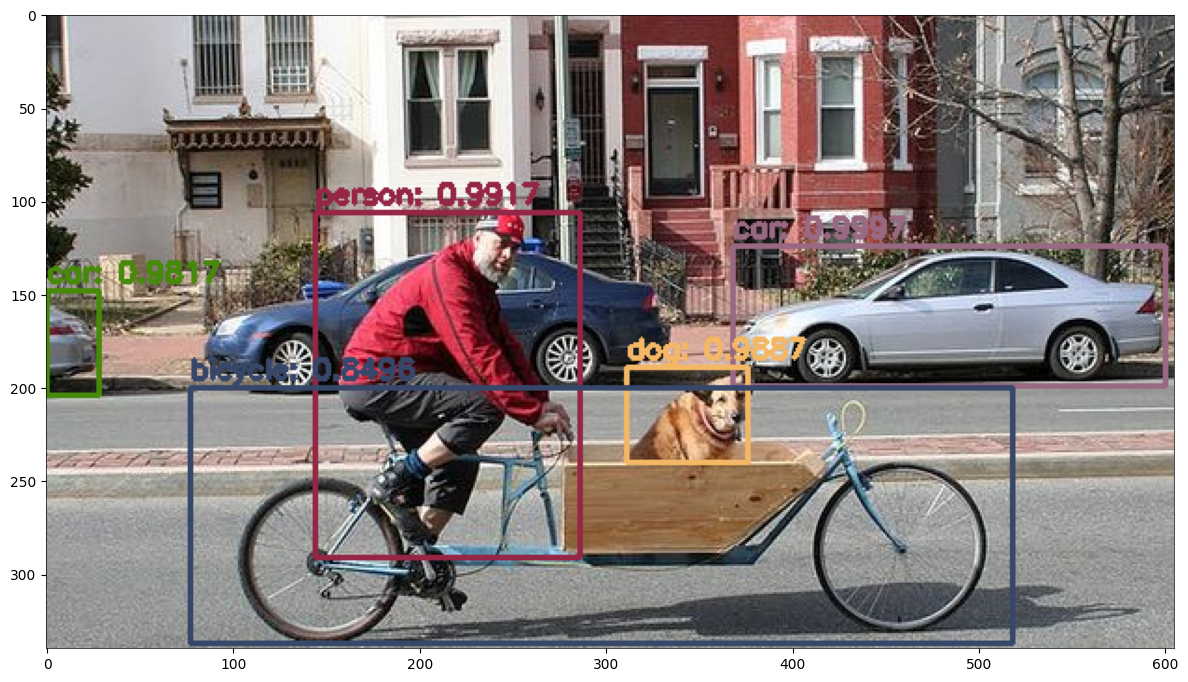

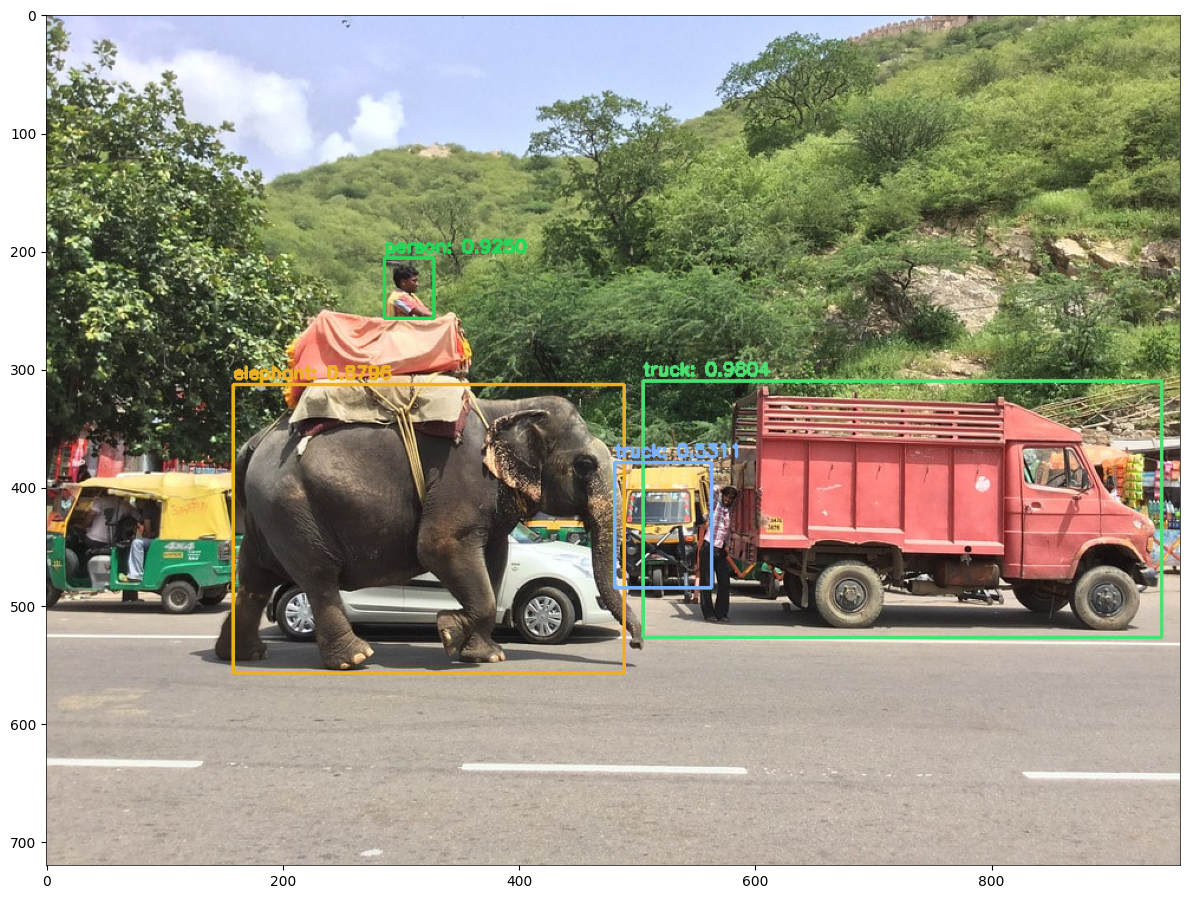

In [19]:
# Set path and get image files
image_path = Path("/content/drive/MyDrive/dataset_directory")
image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.jpeg"))

# Randomly select 5 images
selected_images = random.sample(image_files, min(5, len(image_files)))

# Process and display images one by one
for i, image_file in enumerate(selected_images, 1):
    # Perform YOLO detection
    image, bounding_boxes, confidences, class_numbers, results = yolo_detection(image_file)

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results)

    # Create a figure for this image
    plt.figure(figsize=(12, 10))

    # Display the image
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))

    # Add a thin border around the image
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

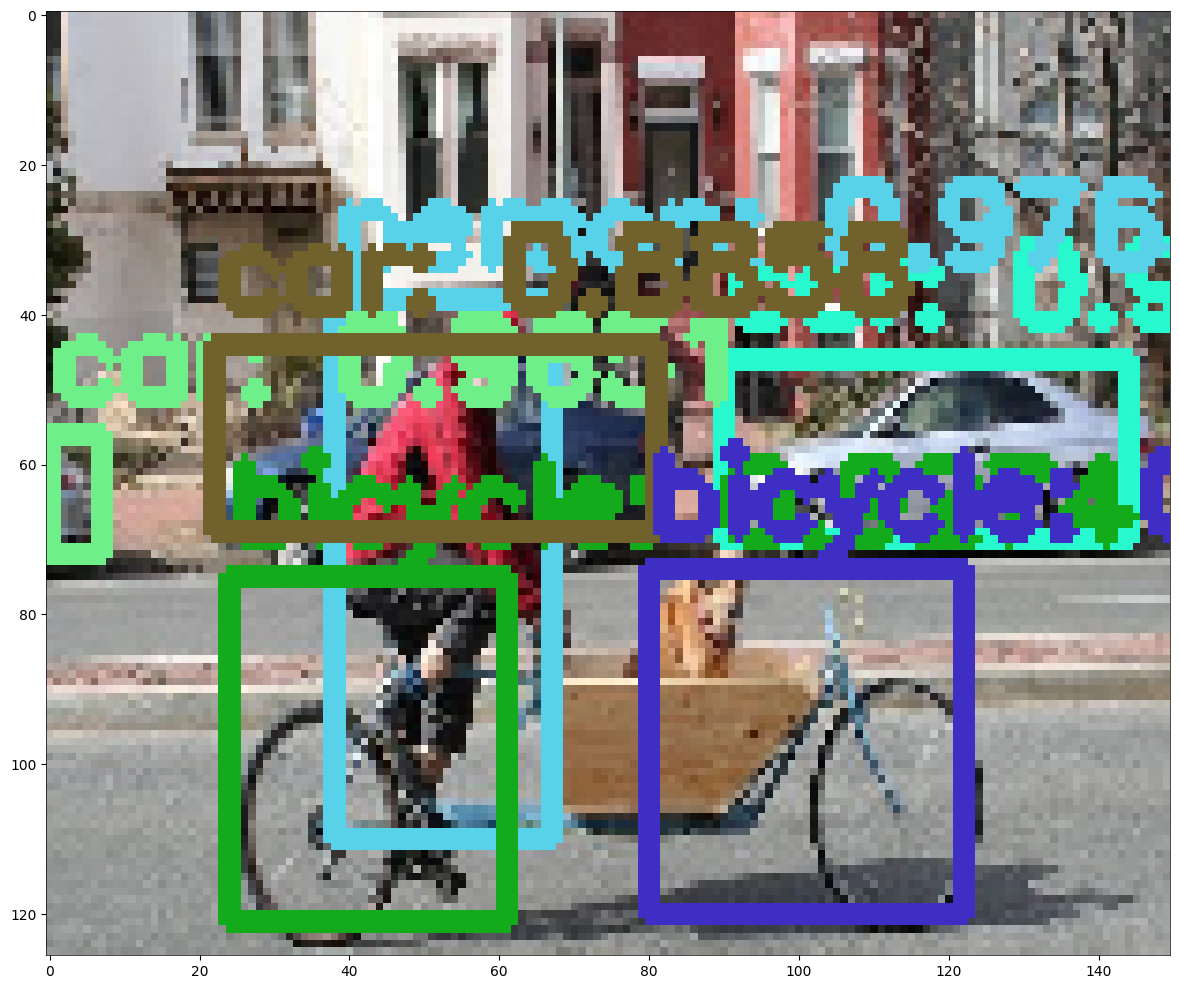

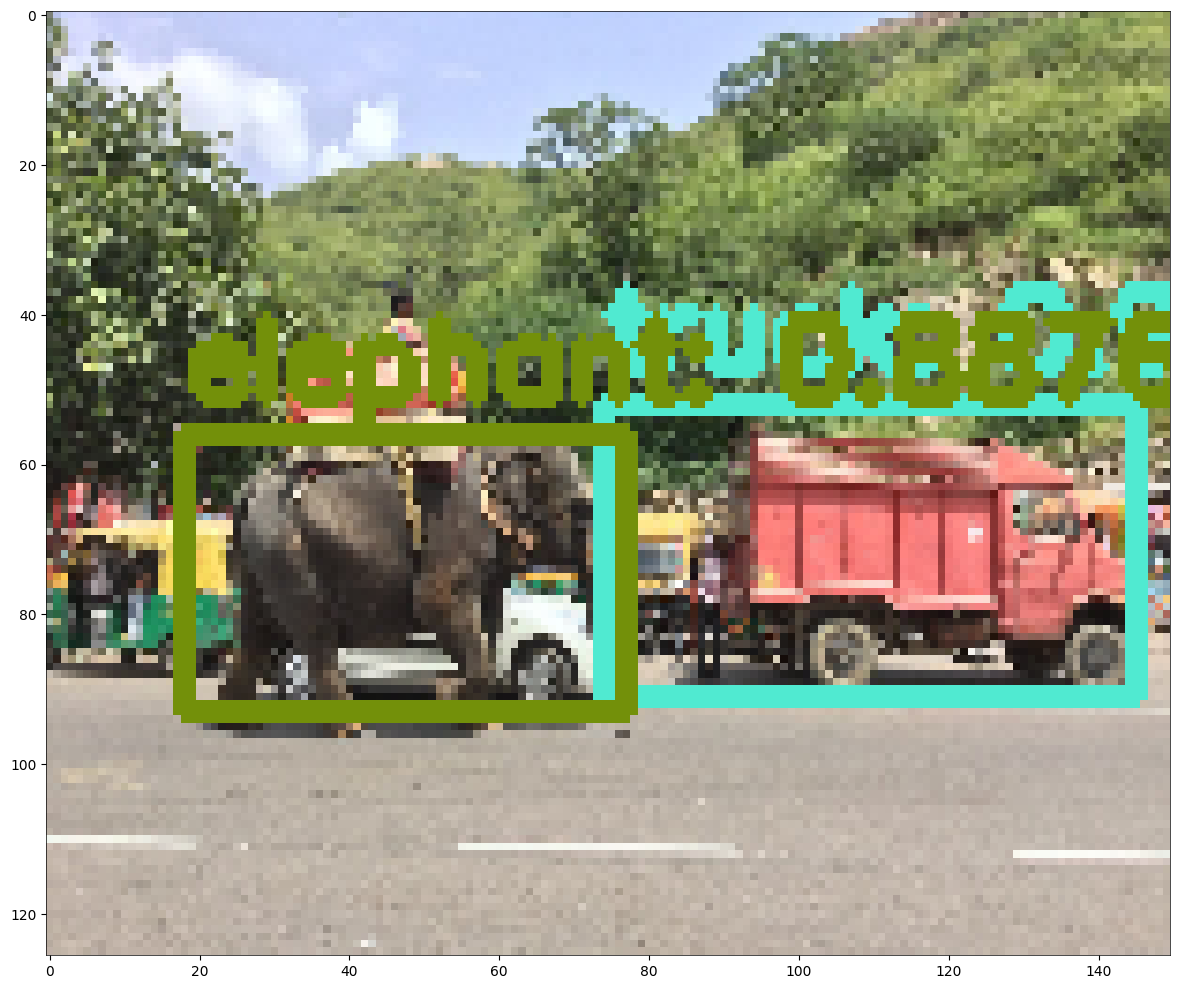

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

def resize_image(image, target_size=(150, 126)):
    return cv2.resize(image, target_size)

def yolo_detection(image):
    # Get the original dimensions
    h, w = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1/100.0, (250, 250), swapRB=True, crop=False)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)

    # Initialize the lists to hold results
    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    # Perform Non-Maximum Suppression
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    return image, bounding_boxes, confidences, class_numbers, results if len(results) > 0 else []

# Set the path and get image files
image_path = Path("/content/drive/MyDrive/dataset_directory")
image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.jpeg"))

# Randomly select 5 images
selected_images = random.sample(image_files, min(5, len(image_files)))

# Process and display images one by one
for i, image_file in enumerate(selected_images, 1):
    # Read and resize the image
    image = cv2.imread(str(image_file))

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Unable to read image {image_file}.")
        continue  # Skip this iteration if the image is not valid

    resized_image = resize_image(image)

    # Perform YOLO detection
    image, bounding_boxes, confidences, class_numbers, results = yolo_detection(resized_image)

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results)

    # Create a figure for this image
    plt.figure(figsize=(12, 10))

    # Display the image
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))

    # Add a thin border around the image
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


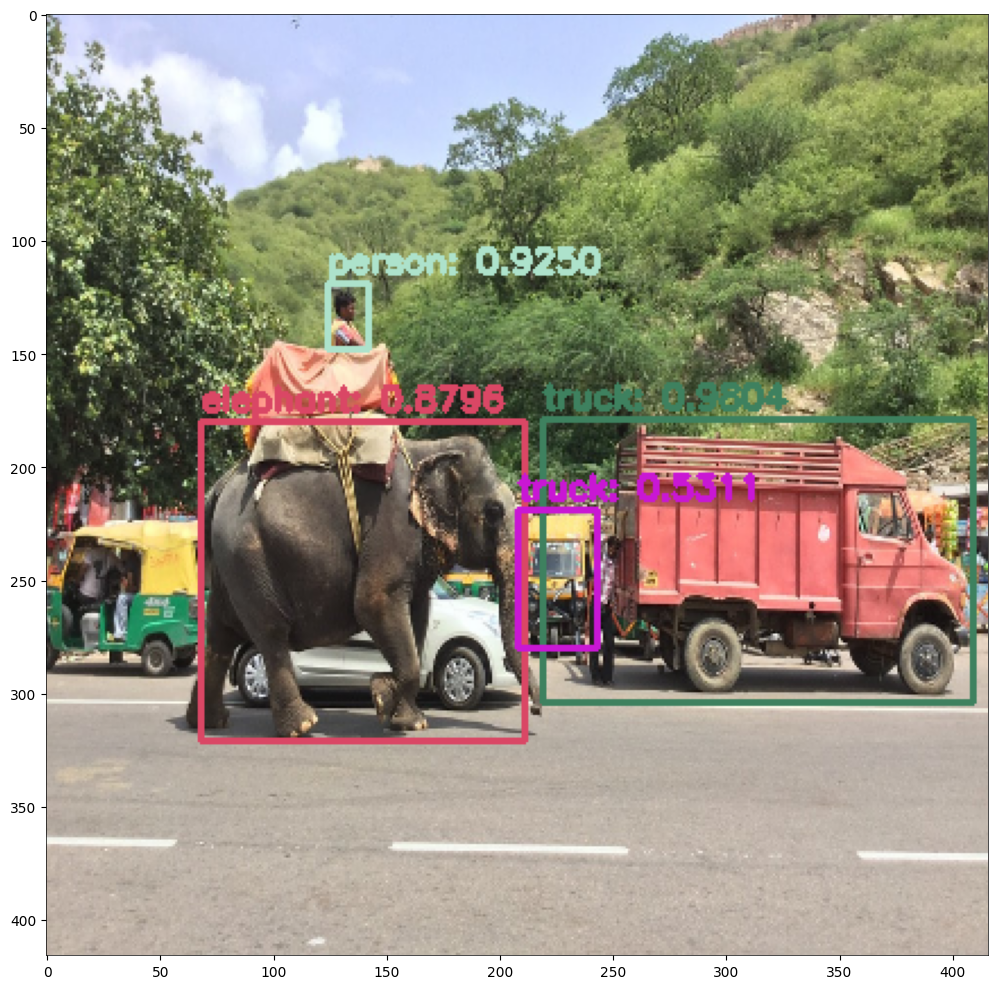

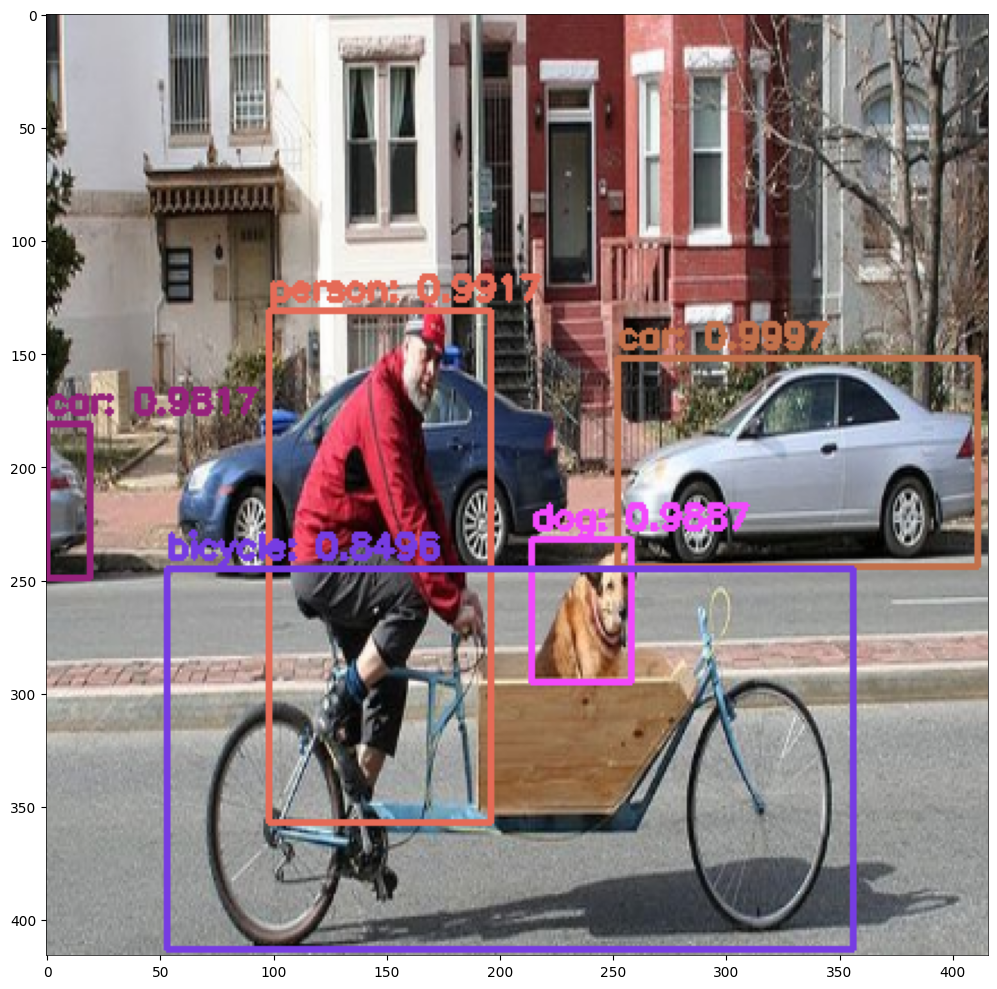

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path


# Function to normalize pixel values of an image (for further processing if needed)
def normalize_image(image):
    return image.astype(np.float32) / 255.0  # Normalize pixel values to the range [0, 1]

def yolo_detection(image):
    # Get the original dimensions
    h, w = image.shape[:2]

    # Create a blob from the original image (normalized)
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)

    # Initialize the lists to hold results
    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    # Perform Non-Maximum Suppression
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    return image, bounding_boxes, confidences, class_numbers, results if len(results) > 0 else []

# Set the path and get image files
image_path = Path("/content/drive/MyDrive/dataset_directory")
image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.jpeg"))

# Randomly select 5 images
selected_images = random.sample(image_files, min(5, len(image_files)))

# Process and display images one by one
for i, image_file in enumerate(selected_images, 1):
    # Read and resize the image
    image = cv2.imread(str(image_file))

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Unable to read image {image_file}.")
        continue  # Skip this iteration if the image is not valid

    resized_image = resize_image(image)

    # Perform YOLO detection on the original resized image
    image, bounding_boxes, confidences, class_numbers, results = yolo_detection(resized_image)

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results)

    # Create a figure for this image
    plt.figure(figsize=(12, 10))

    # Display the image
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))

    # Add a thin border around the image
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    """
    Evaluate the YOLO model performance using accuracy, precision, recall, and F1 score.

    Args:
        y_true (list): Ground truth class labels for the objects in the images.
        y_pred (list): Predicted class labels from the YOLO model.

    Returns:
        dict: A dictionary containing the accuracy, precision, recall, and F1 score.
    """
    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Example of how to use the evaluate_model function
# Assuming you have lists of true and predicted classes
y_true = [1, 2, 3, 1, 2]  # Example ground truth labels
y_pred = [1, 2, 2, 1, 3]  # Example predicted labels from the model

metrics = evaluate_model(y_true, y_pred)
print("Performance Metrics:")
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")


Performance Metrics:
Accuracy: 0.60
Precision: 0.60
Recall: 0.60
F1 Score: 0.60


In [69]:
import time

def measure_inference_time(image):
    """
    Measure the time taken for the YOLO model to detect objects in an image.

    Args:
        image (numpy.ndarray): The input image for object detection.

    Returns:
        float: The time taken for the model to process the image in seconds.
    """
    start_time = time.time()  # Start the timer

    # Perform YOLO detection
    _, bounding_boxes, confidences, class_numbers, results = yolo_detection(image)

    end_time = time.time()  # End the timer
    inference_time = end_time - start_time  # Calculate elapsed time

    return inference_time

# Example of how to use the measure_inference_time function
# Assuming you have read and resized your image
image = cv2.imread(str(selected_images[0]))  # Replace with your image file
resized_image = resize_image(image)

# Measure inference time
inference_time = measure_inference_time(resized_image)
print(f"Inference Time: {inference_time:.4f} seconds")


Inference Time: 2.0034 seconds
